# HR Analytics - Employee Attrition

### Muhammad Rizky Farhan

**Dataset:** HR Analytics Case Study | **Source:** [kaggle.com](https://www.kaggle.com/vjchoudhary7/hr-analytics-case-study?select=general_data.csv)

**Problem**

A large company named XYZ employs around 4000 employees. However, every year around 15% of it's employees leave the company and needs to be replaced. The management believes that this level of attrition (employees leaving) is bad for the company. Hence the management wanted to understand what factors they should focus on in order to make their employees stay and what factors need to be addressed right away.

**Goal**

Identify what are the most significant factors affecting attrition and making a model to predict new employees attrition.

### I. Importing Data & Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [4]:
import joblib

In [5]:
data = pd.read_csv('labeled_data.csv')

In [6]:
data.head()

,EmployeeID,Gender,MaritalStatus,Education,EducationField,Department,JobRole,JobLevel,MonthlyIncome,BusinessTravel,DistanceFromHome,StockOptionLevel,NumCompaniesWorked,YearsSinceLastPromotion,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,PerformanceRating,Attrition
0,1,1,1,1,0,0,0,1,131160,1,6,0,1.0,0,2,3,2,0,0
1,2,1,0,0,0,1,1,1,41890,2,10,1,0.0,1,2,1,3,1,1
2,3,0,1,3,1,1,2,4,193280,2,17,3,1.0,0,1,1,0,0,0
3,4,0,1,4,0,1,3,3,83210,0,2,3,3.0,7,3,3,1,0,0
4,5,0,0,0,2,1,2,1,23420,1,10,2,4.0,0,3,0,1,0,0


### II. Model Building
In this process, we will go through several steps to find the optimal model to predict and rank the importance between features that are going to be analyzed. As been decided before, the train data or x will include all the features except `EmployeeID` and `Attrition`. The target or y will be `Attrition`.

In [7]:
x = data.drop(['EmployeeID', 'Attrition'], axis = 1)
y = data['Attrition']

In [8]:
y.value_counts()

0    3605
1     695
Name: Attrition, dtype: int64

### II.1 Data Splitting

First, the data will have to be split into 2 subsets which are train data and test data. As the name implies the data will be used for different purpose which are training and testing. The testing subset is for building the model and the testing subset is used for the model on unknown data to evaluate the performance of the model.

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.30, random_state = 101)

Since the goal of this study is to predict and rank the feature importance of a binary target which have a value of Yes or No, classification algorithms will be used for our model. In this study there will be 10 classification that are going to be used. The models are:

1. Logistic Regression
2. Decision Tree
3. Random Forest
4. Ada Boosting
5. Gradient Boosting
6. Extreme Gradient Boosting
7. Naive-Bayes
8. Multi-Layer Perceptron
9. Support Vector
10. K-Nearest Neighbor

The steps that are going to be used in building the model are:
1. Make hyperparameter grid for each model
2. Do hyperparameter tuning using GridSearchCV as well as calculating best score for each model
3. Compare best scores and choosing the best model
4. Oversample the data with SMOTE
5. Compare the results between original and oversampled data
6. Decide on the final model
7. Rank feature importances
8. Choose the most significant features
9. Build final model with chosen features

### II.2 Initiating Models and Parameters

In [10]:
RS = 101
MODELS = [
    LogisticRegression(random_state = RS),
    DecisionTreeClassifier(random_state = RS),
    AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = RS), algorithm = 'SAMME',random_state = RS),
    GradientBoostingClassifier(random_state = RS),
    XGBClassifier(random_state = RS),
    RandomForestClassifier(random_state = RS),
    AdaBoostClassifier(base_estimator = RandomForestClassifier(random_state = RS), algorithm='SAMME', random_state = RS),
    GaussianNB(),
    KNeighborsClassifier(),
    SVC(random_state = RS, probability = True),
    MLPClassifier(random_state = RS)
]

NAMES = [
    'Logistic',
    'Decision Tree',
    'DT - AdaBoost',
    'Gradient Boost',
    'XGBoost',
    'Random Forest Classifier',
    'RFC - AdaBoost',
    'GaussianNB',
    'KNN',
    'SVC',
    'Multi-Layer Perceptron'
]

In [11]:
logreg_params= {
    "C": np.logspace(-1, 1, 10),
    "solver":['lbfgs', 'liblinear', 'sag', 'saga'],
    "max_iter":[1000]
}

dtree_params = {
    "min_samples_split" : range(10,500,20),
    "max_depth": np.linspace(1,20,4)
}

ada_param = {
    "n_estimators" : [10,20,40],
    "learning_rate" : np.linspace(0.01,0.1,5)
}

gb_param = {
    "n_estimators" : [10,20,40],
    "learning_rate" : np.linspace(0.01,0.1,5)
}
            
xgb_params = {
    "n_estimators": [10, 20, 40],
    "subsample": [ 0.6, 0.8, 1.0],
    "max_depth": [1,2,3,4],
    "learning_rate": [0.1,0.2, 0.3, 0.4, 0.5]
}

rfc_params = {
    "min_samples_split" : range(10,500,20),
    "max_depth": np.linspace(1,20,4)
}

ada_rfc_param = {
    "n_estimators" : [10,20,40],
    "learning_rate" : np.linspace(0.01,0.1,5)
}

NB_params = {
    "var_smoothing": np.logspace(0,-9, num=100)
}

knn_params= {
    "n_neighbors": np.linspace(1,19,10, dtype = int).tolist(),
    "weights": ["uniform","distance"],
    "metric": ["euclidean","manhattan"]
}

svc_params= {
    "kernel" : ["rbf"],
    "gamma": [0.1, 1, 5, 10],
    "C": [1,10,50,100]
}

mlpc_params = {
    "alpha": [0.1, 0.05, 0.01],
    "hidden_layer_sizes": [(10,10,10),(100,100,100),(100,100)],
    "solver" : ["lbfgs","adam","sgd"],
    "max_iter":[1000]
}

PARAMS = [
    logreg_params,
    dtree_params,
    ada_param,
    gb_param,
    xgb_params,
    rfc_params,
    ada_rfc_param,
    NB_params,
    knn_params,
    svc_params,
    mlpc_params
]

### II.3 Hyperparameter Tuning and Calculating Best Score

In [12]:
scores = []
cv_result = {}
best_estimators = {}
for name, model,classifier_param in zip(NAMES, MODELS, PARAMS):
    clf = GridSearchCV(model, param_grid = classifier_param, cv = 10, scoring = "accuracy", n_jobs = -1,verbose = False)
    clf.fit(xtrain,ytrain)
    cv_result[name] = clf.best_score_
    scores.append(cv_result[name])
    best_estimators[name] = clf.best_estimator_
    print(name + ' best score: ' + str(cv_result[name]))
print('\nHighest best score: ' + str(max(scores)) + ' (' + NAMES[scores.index(max(scores))] + ')')

Logistic best score: 0.841860465116279
Decision Tree best score: 0.9056478405315614
DT - AdaBoost best score: 0.9634551495016612
Gradient Boost best score: 0.8534883720930233
XGBoost best score: 0.9308970099667775
Random Forest Classifier best score: 0.9186046511627908
RFC - AdaBoost best score: 0.9790697674418606
GaussianNB best score: 0.841860465116279
KNN best score: 0.9757475083056478
SVC best score: 0.9780730897009967
Multi-Layer Perceptron best score: 0.841860465116279

Highest best score: 0.9790697674418606 (RFC - AdaBoost)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


By comparing the best score for each model, it is found that **Random Forest Classifier with AdaBoosting** has the highest score with the value of **97,9%**.

### II.4 Oversampling with SMOTE
Checking the value count of the target variable, it is considered that the data is imbalance where the proportion of the value 0 is much more than the 1 value. In order to balance the data, oversampling is going to be used. Oversampling will be done using SMOTE technique, where the minority class will be duplicated to the same number of samples.

In [13]:
y.value_counts()

0    3605
1     695
Name: Attrition, dtype: int64

In [14]:
sm = SMOTE(random_state = 101)
os_xtrain, os_ytrain = sm.fit_sample(xtrain, ytrain)
os_train = pd.concat([pd.DataFrame(os_ytrain), pd.DataFrame(os_xtrain)], axis=1)

In [15]:
pd.Series(os_ytrain).value_counts()

1    2534
0    2534
Name: Attrition, dtype: int64

In [16]:
model = AdaBoostClassifier(base_estimator = RandomForestClassifier(random_state = RS), algorithm='SAMME', random_state = RS)
classifier_param = {
    "n_estimators" : [10,20,40],
    "learning_rate" : np.linspace(0.01,0.1,5)
}

clf = GridSearchCV(model, param_grid=classifier_param, cv = 10, scoring = "accuracy", n_jobs = -1,verbose = False)
clf.fit(os_xtrain,os_ytrain)
print(' best score after oversampling: ' + str(clf.best_score_))

 best score after oversampling: 0.9806663236429122


In [17]:
clf.best_params_

{'learning_rate': 0.01, 'n_estimators': 10}

After oversampling the data, the model is once again checked with the same model which is Random Forest Classifier with AdaBoosting. The result of oversampling made the accuracy go up by **0,001596556201**.

### II.5 Ranking Feature Importance
To accomplish our goal and identify what factors that the employee have to focus on and address, we will be ranking the feature importance of the data. Feature importance is a tehcnique that assign a score to input features based on how useful they are at predicting a target variable.

In [18]:
rfc_ada_smote = AdaBoostClassifier(base_estimator = RandomForestClassifier(random_state = 101), learning_rate = 0.01, n_estimators = 10, algorithm='SAMME', random_state = 101)
rfc_ada_smote.fit(os_xtrain, os_ytrain)
print(rfc_ada_smote.feature_importances_)

[0.02776959 0.10653486 0.05490095 0.04775278 0.02712815 0.06305641
 0.04333077 0.12711377 0.02522622 0.08294278 0.03851002 0.09815367
 0.0538833  0.06700671 0.07875248 0.04048922 0.01744831]


In [19]:
feature = pd.DataFrame()
feature['kolom'] = x.columns
feature['importances'] = rfc_ada_smote.feature_importances_
feature

,kolom,importances
0,Gender,0.027770
1,MaritalStatus,0.106535
2,Education,0.054901
3,EducationField,0.047753
4,Department,0.027128
5,JobRole,0.063056
6,JobLevel,0.043331
7,MonthlyIncome,0.127114
8,BusinessTravel,0.025226
9,DistanceFromHome,0.082943


<Figure size 1080x1080 with 0 Axes>

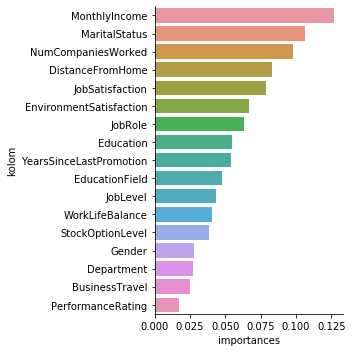

In [20]:
plt.figure(figsize=(15,15))
sns.catplot(y = 'kolom', x = 'importances', data = feature.sort_values(by = 'importances' , ascending = False), kind= 'bar')
plt.tight_layout()

By looking at the graph above, we can see how much each of the feature affects the model prediction. `MonthlyIncome` is identified to be the most useful feature while `PerformanceRating` is identified to be the least useful. In the actual application, it is almost impossible to address all of these features as it will need a lot of resources and time. So to make the improvement more feasible and more effective it is best to focus on the most important features. The **top 5 feature** is decided to be the most important feature and will be chosen as the focus.

### II.5 Final Model with Chosen Features
After choosing the most important feature, the model building process is repeated by using the same process but only using 5 features that are chosen.

In [7]:
new_x = data[['MonthlyIncome', 'MaritalStatus', 'NumCompaniesWorked', 'DistanceFromHome', 'JobSatisfaction']]
new_y = data['Attrition']

In [8]:
new_xtrain, new_xtest, new_ytrain, new_ytest = train_test_split(new_x, new_y, test_size = 0.30, random_state = 101)

In [23]:
new_scores = []
new_cv_result = {}
new_best_estimators = {}
for name, model,classifier_param in zip(NAMES, MODELS, PARAMS):
    new_clf = GridSearchCV(model, param_grid = classifier_param, cv = 10, scoring = "accuracy", n_jobs = 2,verbose = False)
    new_clf.fit(new_xtrain,new_ytrain)
    new_cv_result[name] = new_clf.best_score_
    new_scores.append(new_cv_result[name])
    new_best_estimators[name] = new_clf.best_estimator_
    print(name + ' best score: ' + str(new_cv_result[name]))
print('\nHighest best score: ' + str(max(new_scores)) + ' (' + NAMES[new_scores.index(max(new_scores))] + ')')

Logistic best score: 0.841860465116279
Decision Tree best score: 0.888704318936877
DT - AdaBoost best score: 0.9641196013289038
Gradient Boost best score: 0.8488372093023255
XGBoost best score: 0.8840531561461795
Random Forest Classifier best score: 0.9013289036544851


/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RFC - AdaBoost best score: 0.9740863787375416
GaussianNB best score: 0.841860465116279
KNN best score: 0.9727574750830564
SVC best score: 0.9767441860465118
Multi-Layer Perceptron best score: 0.841860465116279

Highest best score: 0.9767441860465118 (SVC)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [31]:
new_best_estimators['SVC']

SVC(C=1, gamma=1, probability=True, random_state=101)

In this new model **Support Vector Classifier** is chosen with a best score of **97,7%**.

In [24]:
sm = SMOTE(random_state = 101)
new_os_xtrain, new_os_ytrain = sm.fit_sample(new_xtrain, new_ytrain)
new_os_train = pd.concat([pd.DataFrame(new_os_ytrain), pd.DataFrame(new_os_xtrain)], axis=1)

In [25]:
new_os_model = SVC(random_state = 101, probability = True)
new_os_classifier_param = {
    "kernel" : ["rbf"],
    "gamma": [0.1, 1, 5, 10],
    "C": [1,10,50,100]
}

new_os_clf = GridSearchCV(new_os_model, param_grid= new_os_classifier_param, cv = 10, scoring = "accuracy", n_jobs = -1,verbose = False)
new_os_clf.fit(new_os_xtrain,new_os_ytrain)
print(' best score after oversampling: ' + str(new_os_clf.best_score_))

 best score after oversampling: 0.9267948328148996


Oversampling is also used in this new model, but it turns out that it results in lower best score with a value of **92,7%**. This lower score can be caused by overfitting the model or by the nature that Support Vector Classifier is really affected by the change of number in samples.

### II.6 Joblib
After optimizing and finding the best model, the last step is to save the model using joblib. The model is needed to be saved into joblib so it can be used in the next process. The model chosen is the **Support Vector Classifier** without oversampling.

In [9]:
final_model = SVC(C = 1, gamma = 1, kernel = 'rbf', random_state = 101, probability = True)
final_model.fit(new_xtrain,new_ytrain)

SVC(C=1, gamma=1, probability=True, random_state=101)

In [10]:
joblib.dump(final_model, 'svc_final')

['svc_final']